In [389]:
library(metacell)
library(GEOquery)
library(googlesheets4)
library(googledrive)
library(devtools)
library(reshape2)
library(plyr)
library(dplyr)
library(tibble)
library(ggplot2)
library(tidyverse)
library(tgstat)
library(tgconfig)
library(gridExtra)
library(SingleCellExperiment)
library(babelgene)
library(zellkonverter)
library(liana)
library(ComplexHeatmap)
library(grid)
library(GOfuncR)
library(cowplot)
library(R.utils)
library(Hmisc)
library(corrplot)
library(pheatmap)
library(shades)
library(seriation)
library(dendextend)
library(readxl)
library(rstatix)

In [391]:
if(!dir.exists("scdb")) dir.create("scdb/")
scdb_init("scdb/", force_reinit=T)
#> initializing scdb to testdb/

initializing scdb to scdb/



In [392]:
if(!dir.exists("final_figs")) dir.create("final_figs/")
scfigs_init("final_figs/")

In [393]:
annot_df <- read.csv("annotations/kinetics_annots.csv", sep=",")
annot_df$label = trimws(annot_df$label)

In [18]:
mcell_mc_add_annot("kinetics_mc", annot_df$label)
mcell_mc_add_color("kinetics_mc", annot_df$color)

In [394]:
mat = scdb_mat("kinetics_singlets")
mc = scdb_mc("kinetics_mc")

In [396]:
bad_genes = as.character(read_lines('annotations/kinetics_filtered_genes.txt'))
rp_markers = grep("Rpl|Rps|Snor|Gm|Ig[h,k,l]v|^mt-|Hist|Hsp|Jun|Rik", colnames(mat@mat), v=T)

In [397]:
FACS_filters = c("CD45+", "CD45-", "EPCAM")
ages = age_order = c("10d", "3w", "6w", "8w", "10w", "12w")
conditions = cond_order = c("tumor", "normal")
age_condition_order = paste(rep(rev(cond_order), each=6), rep(age_order, 2), sep="_")

In [399]:
age_dict = c(10, 3*7, 6*7, 8*7, 10*7, 12*7)
names(age_dict) = age_order

In [400]:
for (i in 1:length(unique(annot_df$label))){
    print(paste(i, unique(annot_df$label)[i], sep=": "))
}

[1] "1: Endothelial"
[1] "2: doublets"
[1] "3: Mcam Endothelial"
[1] "4: Dpp4 fibroblasts"
[1] "5: fibroblasts"
[1] "6: CAFs"
[1] "7: Schwann cells"
[1] "8: Smooth muscle"
[1] "9: Pericytes"
[1] "10: Tumor cells"
[1] "11: Progenitor 1"
[1] "12: Alveolar"
[1] "13: Progenitor 2"
[1] "14: HS"
[1] "15: Basal"
[1] "16: Hair-like"
[1] "17: MyoLum"
[1] "18: Myoepithelial"
[1] "19: Mast cells"
[1] "20: NK cells"
[1] "21: gd NKT"
[1] "22: Mreg DCs"
[1] "23: Basophils"
[1] "24: B cells"
[1] "25: T cells"
[1] "26: CD8 T cells"
[1] "27: Treg"
[1] "28: ILC2"
[1] "29: Perivasc macs"
[1] "30: Neutrophils"
[1] "31: Monocytes"
[1] "32: MonMacs"
[1] "33: cDC2"
[1] "34: Ductal macs"
[1] "35: pDC"
[1] "36: cDC1"


In [401]:
doublet_order = c(2, 16)
doublet_clusters = unique(annot_df$label)[doublet_order]
lymphoid_order = c(25, 26, 27, 21, 20, 28, 24)
myeloid_order = c(31, 32, 29, 34, 36, 33, 35, 22, 19, 23, 30)
epithelial_order = c(11, 13, 12, 14, 18, 15, 17, 10)
stromal_order = c(1, 3, 8, 9, 7)
fibroblast_order = c(5, 4, 6)

In [402]:
pop_orders = list(lymphoid=unique(annot_df$label)[lymphoid_order],
                  myeloid=unique(annot_df$label)[myeloid_order],
                  epithelial=unique(annot_df$label)[epithelial_order],
                  stromal=unique(annot_df$label)[stromal_order],
                  fibroblast=unique(annot_df$label)[fibroblast_order])

In [403]:
cell_type_annots = list(unique(annot_df$label)[c(lymphoid_order, myeloid_order)], 
                        unique(annot_df$label)[c(stromal_order, fibroblast_order)],
                        unique(annot_df$label)[epithelial_order])
names(cell_type_annots) = FACS_filters

In [404]:
order_index = c(lymphoid_order, myeloid_order, epithelial_order, stromal_order, fibroblast_order)
cell_order = unique(annot_df$label)[order_index]

In [415]:
mat@cell_metadata[mc@annots[mc@mc[mat@cells]] %in% cell_order,] %>%
    group_by(Age, condition, Cell_type) %>%
    summarise(n_replicates = length(unique(Replicate)), n_plates=length(unique(Amp.Batch.ID)), n_cells=n()) %>%
    mutate(Age = factor(Age, levels=age_order)) %>%
    arrange(Age, condition, Cell_type) %>%
    write_csv("final_figs/supp1/nums_table.csv")

`summarise()` has grouped output by 'Age', 'condition'. You can override using
the `.groups` argument.


In [422]:
group.colors = annot_df$color[match(cell_order, annot_df$label)]
names(group.colors) = cell_order

In [423]:
good_cellnames = names(mc@mc[mc@annots[mc@mc] %in% cell_order])

In [424]:
full_df = cbind(subset(mat@cell_metadata[good_cellnames,], select=-metacell), 
                metacell=mc@mc[good_cellnames], 
                annotation=mc@annots[mc@mc[good_cellnames]])

In [161]:
replicate_df = full_df %>%
    group_by(annotation, Age, condition, Cell_type, Replicate) %>% 
    summarise(Count=length(annotation)) %>% drop_na() %>% as.data.frame %>%
    tidyr::complete(annotation, Age, condition, Cell_type, Replicate, fill=list(Count=0))

replicate_df = replicate_df[apply(replicate_df, 1, 
                                  function(x) {x['annotation'] %in% unlist(cell_type_annots[x['Cell_type']])}),] %>%
    group_by(Age, condition, Cell_type, Replicate) %>% 
    summarise(Cell_type=Cell_type, 
              annotation=annotation, 
              Count=Count, 
              total=sum(Count), 
              fraction = Count / sum(Count),
              Replicate = Replicate) %>% 
    filter(total != 0)

replicate_df$annotation = factor(replicate_df$annotation, levels=cell_order)
replicate_df$condition = factor(replicate_df$condition, levels=cond_order)
replicate_df$Age = factor(replicate_df$Age, levels=age_order)
replicate_df$Replicate = factor(replicate_df$Replicate, levels=1:5)

`summarise()` has grouped output by 'annotation', 'Age', 'condition',
'Cell_type'. You can override using the `.groups` argument.
Warning message:
“Returning more (or less) than 1 row per `summarise()` group was deprecated in
dplyr 1.1.0.
ℹ Please use `reframe()` instead.
ℹ When switching from `summarise()` to `reframe()`, remember that `reframe()`
  always returns an ungrouped data frame and adjust accordingly.”
`summarise()` has grouped output by 'Age', 'condition', 'Cell_type',
'Replicate'. You can override using the `.groups` argument.


In [172]:
anova_df = sapply(cell_order, function(pop){
    aov_res = aov(fraction ~ Age + condition, data = replicate_df[replicate_df$annotation == pop,])
    pval_df = TukeyHSD(aov_res, which = "Age")$Age %>% as.data.frame %>% select('p adj')
    pval_df['Age', 'p adj'] = summary(aov_res)[[1]]['Age',"Pr(>F)"]
    pval_df['condition', 'p adj'] = summary(aov_res)[[1]]['condition',"Pr(>F)"]
    return(as.matrix(pval_df))
}) %>% t %>% as.data.frame

In [173]:
colnames(anova_df) = c("3w-10d", "6w-10d", "8w-10d", "10w-10d", "12w-10d", "6w-3w", "8w-3w", "10w-3w", "12w-3w", "8w-6w", 
                       "10w-6w", "12w-6w", "10w-8w", "12w-8w", "12w-10w", "Age", "condition")

In [174]:
anova_df = anova_df[c("Age", "condition", "3w-10d", "6w-10d", "8w-10d", "10w-10d", "12w-10d", "6w-3w", "8w-3w", "10w-3w", 
                      "12w-3w", "8w-6w", "10w-6w", "12w-6w", "10w-8w", "12w-8w", "12w-10w")]

In [175]:
corr_anova_df = mutate_all(anova_df, function(x){p.adjust(x, method='fdr')})

In [176]:
anova_df_plt = corr_anova_df %>%
    select(Age, condition) %>%
    rownames_to_column('annotation') %>%
    melt(variable.name = "Variable", value.name = "p_adj") %>%
    mutate(annotation = factor(annotation, levels=cell_order))

Using annotation as id variables



In [232]:
annot_to_pop = sapply(names(pop_orders), function(x){
    l = rep(x, length(pop_orders[[x]]))
    names(l) = pop_orders[[x]]
    return(l)
}) %>% unlist

In [233]:
annot_to_pop_names = str_split_i(names(annot_to_pop), "\\.", 2)

In [234]:
annot_to_pop = annot_to_pop %>% str_replace("fibroblast", "stromal")
names(annot_to_pop) = annot_to_pop_names

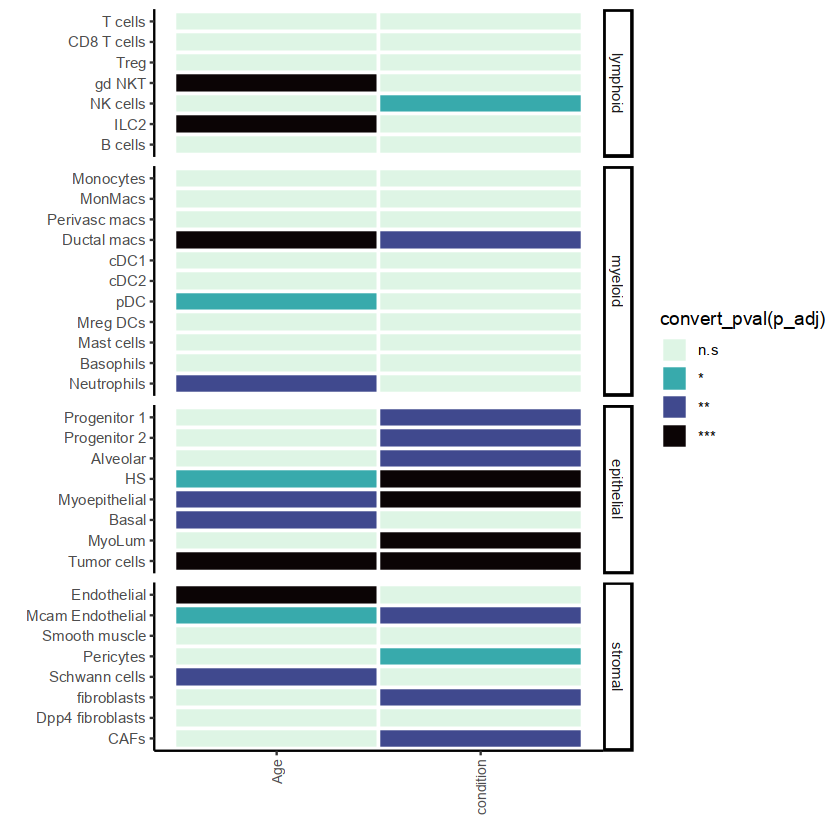

In [247]:
ggplot(anova_df_plt %>% 
           mutate(pop=factor(annot_to_pop[annotation], levels=names(pop_orders)),
                  annotation=factor(annotation, levels=rev(cell_order))), 
       aes(y=annotation, x=Variable, fill=convert_pval(p_adj), label=convert_pval(p_adj))) +
    geom_tile(color = "white", lwd = 0.75) +
    #geom_text() +
    scale_fill_viridis_d(option="G", direction = -1) +
    labs(legend="", y="", x="") +
    facet_grid(rows='pop', scale='free_y', space = 'free_y') +
    theme(axis.text.x = element_text(angle = 90, hjust=1, vjust=0.5, size=8))
ggsave("revision_figs/anova_hm_sig.pdf", width = 3.75, height = 10)

In [5]:
facs_data = read_excel("/home/orimosko/projects/updated_breast/kinetic percentages (6).xlsx")

New names:
• `` -> `...2`
• `` -> `...8`
• `` -> `...9`
• `` -> `...10`


In [285]:
mfi_data = read_csv("MFI.csv")

Rows: 18 Columns: 4
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): FACS.gate, Date, Age
dbl (1): MFI

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [6]:
colnames(facs_data) = str_replace(colnames(facs_data), " ", ".")

In [7]:
facs_colors = c('#3fddd5', '#dd0505', '#dd50ac', '#a56f35', '#41a520')
names(facs_colors) = unique(facs_data$FACs.Filter)

In [8]:
colnames(facs_data)[2] = 'batch_name'

In [11]:
facs_data = facs_data %>% mutate(Age = factor(Age, levels = age_order), 
                                 Condition = factor(Condition, levels = c('Tumor', 'Normal')))

# Figure 1

In [42]:
if(!dir.exists("final_figs/fig1")) dir.create("final_figs/fig1/")

In [584]:
m2d = scdb_mc2d("kinetics_2dproj")

In [585]:
mc_2d = data.frame(x=m2d@sc_x[!mc@annots[mc@mc[names(m2d@sc_x)]] %in% doublet_clusters], 
                   y=m2d@sc_y[!mc@annots[mc@mc[names(m2d@sc_y)]] %in% doublet_clusters], 
                   annotation=mc@annots[mc@mc[names(m2d@sc_y[!mc@annots[mc@mc[names(m2d@sc_y)]] %in% doublet_clusters])]])
mc_2d = mc_2d %>% mutate(annotation=factor(annotation, levels=cell_order))

In [109]:
# B

p = ggplot(mc_2d, aes(x=x, y=y, col=annotation)) +
    geom_point(size=0.5, show.legend = F) +
    geom_bar(aes(y=0, fill=annotation), stat="identity", color="white") +
    scale_color_manual(values = group.colors[names(group.colors) %in% mc_2d$annotation]) +
    scale_fill_manual(values = group.colors[names(group.colors) %in% mc_2d$annotation]) +
    theme(axis.title.x = element_blank(), axis.title.y = element_blank(), #legend.text=element_blank(), 
    axis.text.x = element_blank(), axis.text.y = element_blank(),
    axis.ticks.x = element_blank(), axis.ticks.y = element_blank(),
    axis.line.x = element_blank(), axis.line.y = element_blank(), )

l = get_legend(p)
p = plot_grid(p + theme(legend.position="none"))

ggsave("final_figs/fig1/2d_visualization.png", plot = p, width = 9, height = 9, dpi=1200)
ggsave("final_figs/fig1/legend.pdf", plot=l, width = 9)

Warning message:
“Removed 1313 rows containing missing values (`position_stack()`).”
Warning message:
“Removed 1313 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 1313 rows containing missing values (`position_stack()`).”
Warning message:
“Removed 1313 rows containing missing values (`geom_point()`).”
Saving 9 x 6.67 in image


In [47]:
# B - no letters

p = ggplot(mc_2d, aes(x=x, y=y, col=annotation)) +
    geom_bar(aes(y=0, fill=annotation), stat="identity", color="white") +
    scale_fill_manual(values = group.colors[names(group.colors) %in% mc_2d$annotation]) +
    theme(axis.title.x = element_blank(), axis.title.y = element_blank(), legend.text=element_blank(), 
    axis.text.x = element_blank(), axis.text.y = element_blank(),
    axis.ticks.x = element_blank(), axis.ticks.y = element_blank(),
    axis.line.x = element_blank(), axis.line.y = element_blank(), )

l = get_legend(p)

ggsave("final_figs/fig1/legend_blank.pdf", plot=l, width = 9)

Warning message:
“Removed 1313 rows containing missing values (`position_stack()`).”
Saving 9 x 6.67 in image


In [110]:
# C

df_2d = data.frame(x=m2d@sc_x[!mc@annots[mc@mc[names(m2d@sc_x)]] %in% doublet_clusters], 
                   y=m2d@sc_y[!mc@annots[mc@mc[names(m2d@sc_y)]] %in% doublet_clusters], 
                   color=mc@colors[mc@mc[names(m2d@sc_y[!mc@annots[mc@mc[names(m2d@sc_y)]] %in% doublet_clusters])]],
                   facs=mat@cell_metadata[names(m2d@sc_y[!mc@annots[mc@mc[names(m2d@sc_y)]] %in% doublet_clusters]),
                                                 "Cell_type"],
                   condition=mat@cell_metadata[names(m2d@sc_y[!mc@annots[mc@mc[names(m2d@sc_y)]] %in% doublet_clusters]),
                                                 "condition"])

gbs = apply(expand.grid(conditions, FACS_filters), 1, function(rowrow){
    df_2d = mutate(df_2d, Color=factor(ifelse(condition == rowrow["Var1"] & facs == rowrow["Var2"], 
                                       df_2d$color, 
                                       "#C0C0C0"),
                                       levels=c("#C0C0C0", unique(df_2d$color)))) 
    ggplot(df_2d %>% arrange(Color), aes(x=x, y=y, color=Color)) +
        geom_point(size=0.01) +
        labs(title = paste(rowrow["Var1"], rowrow["Var2"], sep=" - "), 
             subtitle = paste(sum(df_2d$condition == rowrow["Var1"] & df_2d$facs == rowrow["Var2"], na.rm = T), "cells")) +
        scale_color_identity() +
        theme(plot.title = element_blank(),  
              plot.subtitle = element_blank(),#element_text(size = 10, hjust = 0.5),
              axis.title.x = element_blank(), axis.title.y = element_blank(),
              axis.text.x = element_blank(), axis.text.y = element_blank(),
              axis.ticks.x = element_blank(), axis.ticks.y = element_blank(),
              axis.line.x = element_blank(), axis.line.y = element_blank(),
              aspect.ratio=1)
})

 g <- arrangeGrob(grobs=gbs, ncol=2) #generates g
 ggsave(file="final_figs/fig1/facs_conditions_nonumbers.png", g, dpi=1200) #saves g

Warning message:
“Removed 1313 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 1313 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 1313 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 1313 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 1313 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 1313 rows containing missing values (`geom_point()`).”
Saving 6.67 x 6.67 in image


In [49]:
df_2d = data.frame(x=m2d@sc_x[!mc@annots[mc@mc[names(m2d@sc_x)]] %in% doublet_clusters], 
                   y=m2d@sc_y[!mc@annots[mc@mc[names(m2d@sc_y)]] %in% doublet_clusters], 
                   color=mc@colors[mc@mc[names(m2d@sc_y[!mc@annots[mc@mc[names(m2d@sc_y)]] %in% doublet_clusters])]],
                   facs=mat@cell_metadata[names(m2d@sc_y[!mc@annots[mc@mc[names(m2d@sc_y)]] %in% doublet_clusters]),
                                                 "Cell_type"],
                   condition=mat@cell_metadata[names(m2d@sc_y[!mc@annots[mc@mc[names(m2d@sc_y)]] %in% doublet_clusters]),
                                                 "condition"])

gbs = apply(expand.grid(conditions, FACS_filters), 1, function(rowrow){
    df_2d = mutate(df_2d, Color=factor(ifelse(condition == rowrow["Var1"] & facs == rowrow["Var2"], 
                                       df_2d$color, 
                                       "#C0C0C0"),
                                       levels=c("#C0C0C0", unique(df_2d$color)))) 
    ggplot(df_2d %>% arrange(Color), aes(x=x, y=y, color=Color)) +
        geom_point(size=0.01) +
        labs(title = paste(rowrow["Var1"], rowrow["Var2"], sep=" - "), 
             subtitle = paste(sum(df_2d$condition == rowrow["Var1"] & df_2d$facs == rowrow["Var2"], na.rm = T), "cells")) +
        scale_color_identity() +
        theme(plot.title = element_blank(),  
              axis.title.x = element_blank(), axis.title.y = element_blank(),
              axis.text.x = element_blank(), axis.text.y = element_blank(),
              axis.ticks.x = element_blank(), axis.ticks.y = element_blank(),
              axis.line.x = element_blank(), axis.line.y = element_blank(),
              aspect.ratio=1)
})

 g <- arrangeGrob(grobs=gbs, ncol=2) #generates g
 ggsave(file="final_figs/fig1/facs_conditions.pdf", g) #saves g

Warning message:
“Removed 1313 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 1313 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 1313 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 1313 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 1313 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 1313 rows containing missing values (`geom_point()`).”
Saving 6.67 x 6.67 in image


In [50]:
proportion_df = replicate_df %>% 
    group_by(annotation, Age, condition) %>%
    summarise(fraction=mean(fraction)) %>%
    group_by(annotation, condition) %>% 
    summarise(fraction=mean(fraction)) %>%
    as.data.frame %>%
    reshape(idvar = "annotation", timevar = "condition", direction = "wide") %>%
    mutate(log_ratio = log(fraction.tumor / fraction.normal)) %>%
    `rownames<-`(.$annotation)

`summarise()` has grouped output by 'annotation', 'Age'. You can override using
the `.groups` argument.
`summarise()` has grouped output by 'annotation'. You can override using the
`.groups` argument.


In [51]:
proportion_df = proportion_df[cell_order,]
proportion_df$color = group.colors[proportion_df$annotation]
proportion_df$annotation = factor(proportion_df$annotation, 
                                  levels=proportion_df$annotation[order(proportion_df$log_ratio)])

In [52]:
proportion_df$annotation

[1] T cells          CD8 T cells      Treg             gd NKT          
 [5] NK cells         ILC2             B cells          Monocytes       
 [9] MonMacs          Perivasc macs    Ductal macs      cDC1            
[13] cDC2             pDC              Mreg DCs         Mast cells      
[17] Basophils        Neutrophils      Progenitor 1     Progenitor 2    
[21] Alveolar         HS               Myoepithelial    Basal           
[25] MyoLum           Tumor cells      Endothelial      Mcam Endothelial
[29] Smooth muscle    Pericytes        Schwann cells    fibroblasts     
[33] Dpp4 fibroblasts CAFs            
34 Levels: Alveolar HS Myoepithelial Progenitor 1 Basal ... Mcam Endothelial

In [115]:
range1 = 1:length(lymphoid_order)
range2 = (max(range1)+1):(max(range1)+length(myeloid_order))
range3 = (max(range2)+1):(max(range2)+length(epithelial_order))
range4 = (max(range3)+1):(max(range3)+length(stromal_order))
range5 = (max(range4)+1):(max(range4)+length(fibroblast_order))

In [118]:
proportion_df$annotation = factor(proportion_df$annotation, 
                                  levels=proportion_df$annotation[c(c(range1)[order(proportion_df[range1,"log_ratio"])],
                                                                    c(range2)[order(proportion_df[range2,"log_ratio"])],
                                                                    c(range3)[order(proportion_df[range3,"log_ratio"])],
                                                                    c(range4)[order(proportion_df[range4,"log_ratio"])],
                                                                    c(range5)[order(proportion_df[range5,"log_ratio"])])
                                                                 ]
                                 )

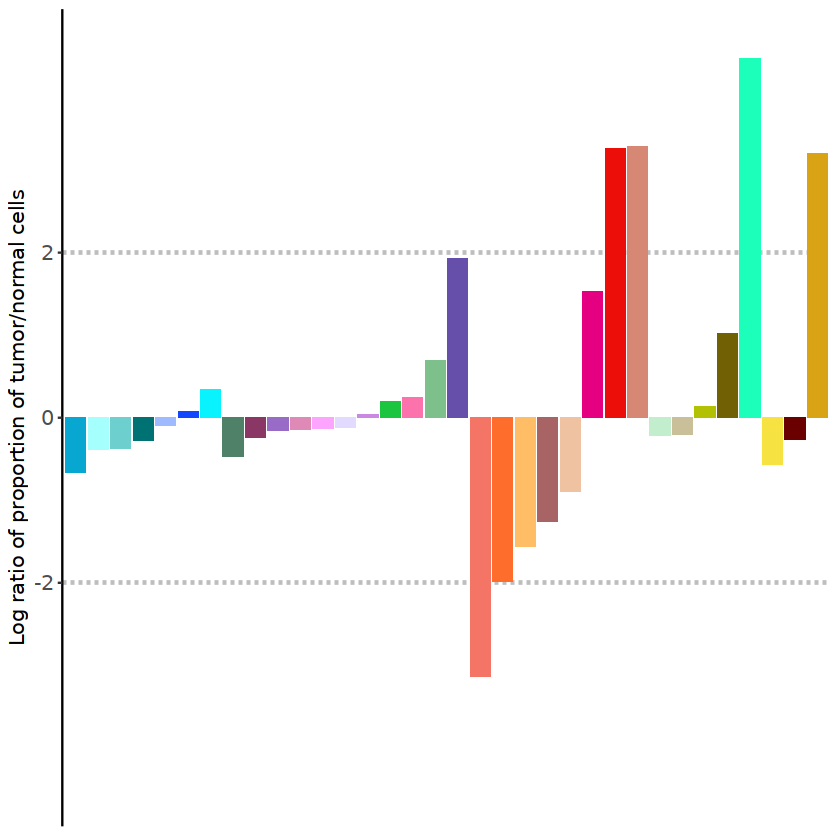

In [119]:
ggplot(proportion_df, aes(x=annotation, y=log_ratio, fill=color)) +
    geom_hline(yintercept=c(-2, 2), linetype="dashed", color="gray", size = 1) +
    geom_bar(stat = "identity", show.legend = F) +
    scale_fill_identity() +
    scale_y_continuous(name="Log ratio of proportion of tumor/normal cells", breaks = c(-2, 0, 2), limits = c(-4.5, 4.5)) + 
    theme(axis.text.x = element_blank(), axis.title.x = element_blank(), 
          axis.ticks.x = element_blank(), axis.line.x = element_blank(),
          axis.title.y = element_text(size=12), axis.text.y = element_text(size=12))

ggsave("final_figs/fig1/log_ratio_bars_all.pdf",
       width = 8, height = 6)

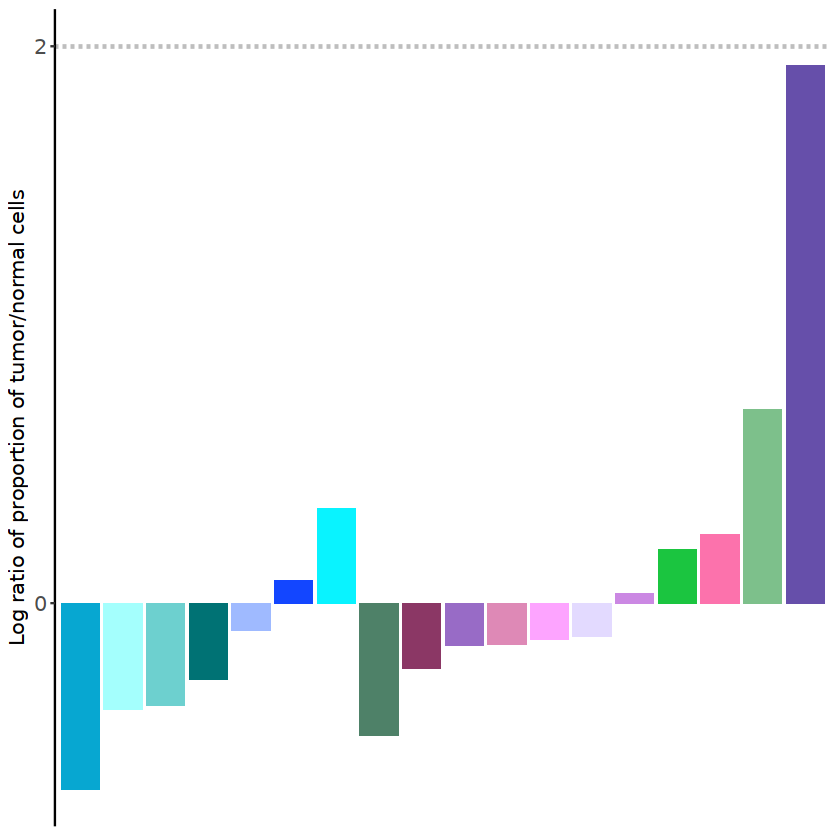

In [120]:
ggplot(proportion_df[proportion_df$annotation %in% cell_order[c(range1, range2)],], aes(x=annotation, y=log_ratio, fill=color)) +
    geom_hline(yintercept=c(2), linetype="dashed", color="gray", size = 1) +
    geom_bar(stat = "identity", show.legend = F) +
    scale_fill_identity() +
    scale_y_continuous(name="Log ratio of proportion of tumor/normal cells", breaks = c(-2, 0, 2)) + 
    theme(axis.text.x = element_blank(), axis.title.x = element_blank(), 
          axis.ticks.x = element_blank(), axis.line.x = element_blank(),
          axis.title.y = element_text(size=12), axis.text.y = element_text(size=12))

ggsave("final_figs/fig1/log_ratio_bars_cd45.pdf",
       width = 6, height = 6)

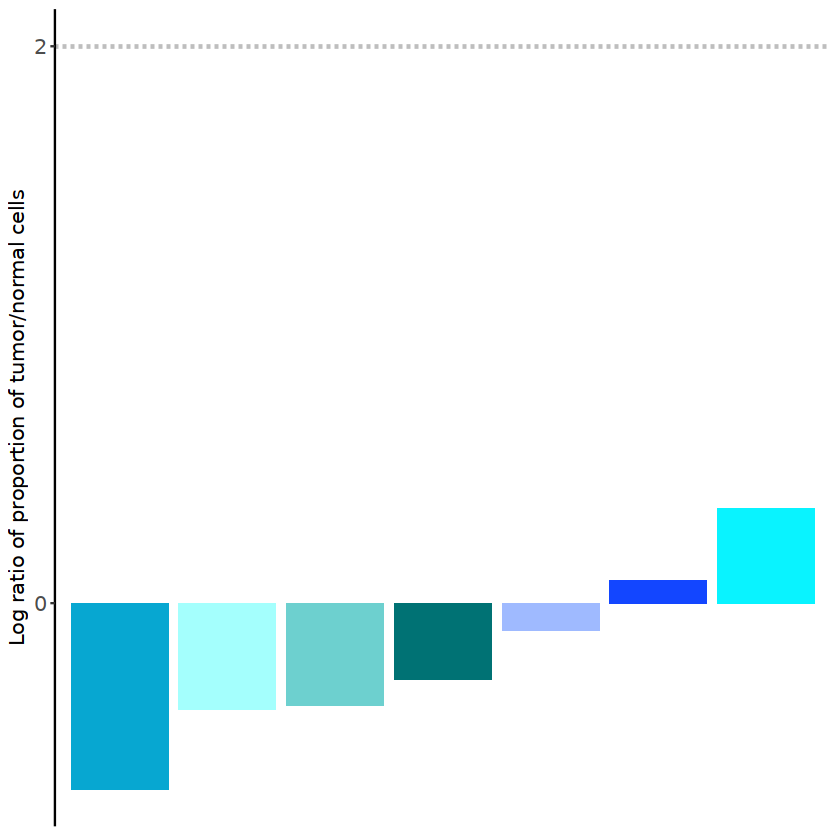

In [121]:
ggplot(proportion_df[proportion_df$annotation %in% cell_order[range1],], aes(x=annotation, y=log_ratio, fill=color)) +
    geom_hline(yintercept=c(2), linetype="dashed", color="gray", size = 1) +
    geom_bar(stat = "identity", show.legend = F) +
    scale_fill_identity() +
    scale_y_continuous(name="Log ratio of proportion of tumor/normal cells", breaks = c(-2, 0, 2)) + 
    theme(axis.text.x = element_blank(), axis.title.x = element_blank(), 
          axis.ticks.x = element_blank(), axis.line.x = element_blank(),
          axis.title.y = element_text(size=12), axis.text.y = element_text(size=12))

ggsave("final_figs/fig1/log_ratio_bars_lymphoid.pdf",
       width = 6, height = 6)

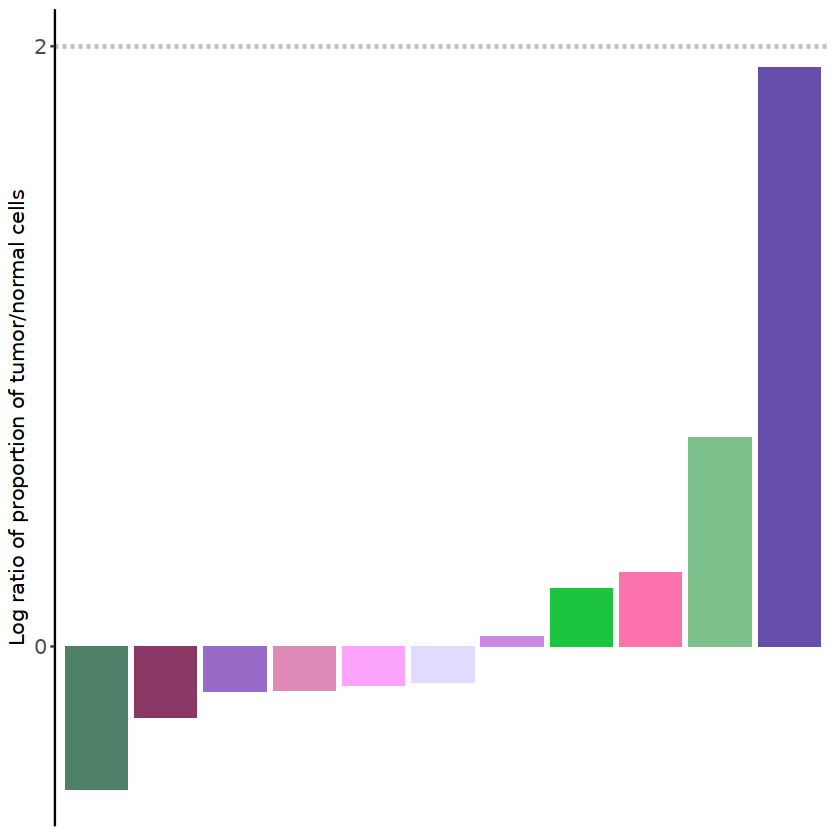

In [122]:
ggplot(proportion_df[proportion_df$annotation %in% cell_order[range2],], aes(x=annotation, y=log_ratio, fill=color)) +
    geom_hline(yintercept=c(2), linetype="dashed", color="gray", size = 1) +
    geom_bar(stat = "identity", show.legend = F) +
    scale_fill_identity() +
    scale_y_continuous(name="Log ratio of proportion of tumor/normal cells", breaks = c(-2, 0, 2)) + 
    theme(axis.text.x = element_blank(), axis.title.x = element_blank(), 
          axis.ticks.x = element_blank(), axis.line.x = element_blank(),
          axis.title.y = element_text(size=12), axis.text.y = element_text(size=12))

ggsave("final_figs/fig1/log_ratio_bars_myeloid.pdf",
       width = 6, height = 6)

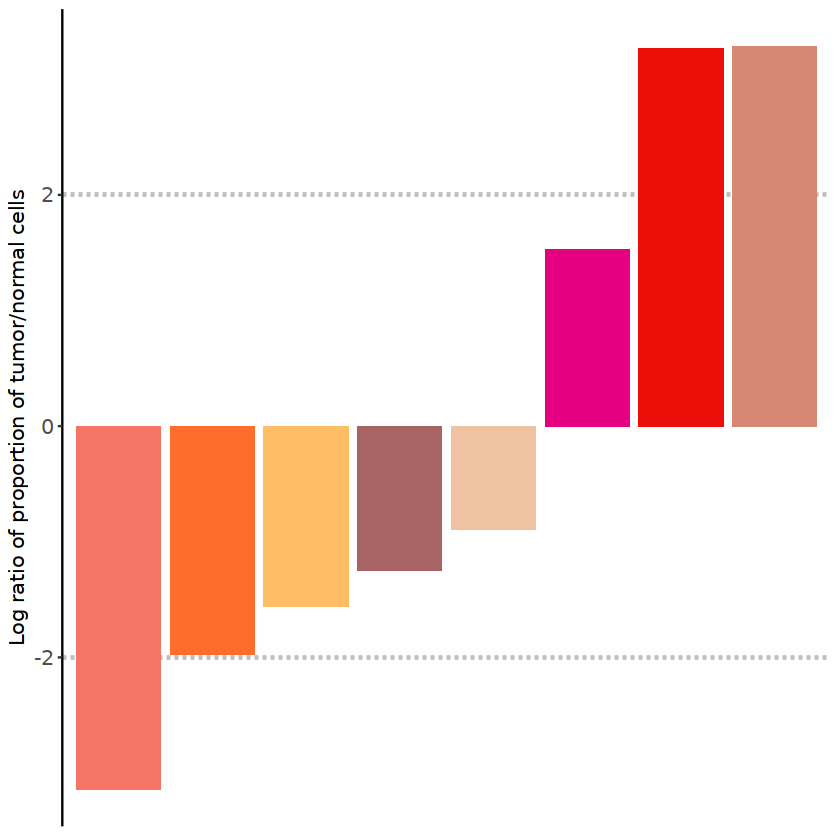

In [123]:
ggplot(proportion_df[proportion_df$annotation %in% cell_order[range3],], aes(x=annotation, y=log_ratio, fill=color)) +
    geom_hline(yintercept=c(-2, 2), linetype="dashed", color="gray", size = 1) +
    geom_bar(stat = "identity", show.legend = F) +
    scale_fill_identity() +
    scale_y_continuous(name="Log ratio of proportion of tumor/normal cells", breaks = c(-2, 0, 2)) + 
    theme(axis.text.x = element_blank(), axis.title.x = element_blank(), 
          axis.ticks.x = element_blank(), axis.line.x = element_blank(),
          axis.title.y = element_text(size=12), axis.text.y = element_text(size=12))

ggsave("final_figs/fig1/log_ratio_bars_epcam.pdf",
       width = 6, height = 6)

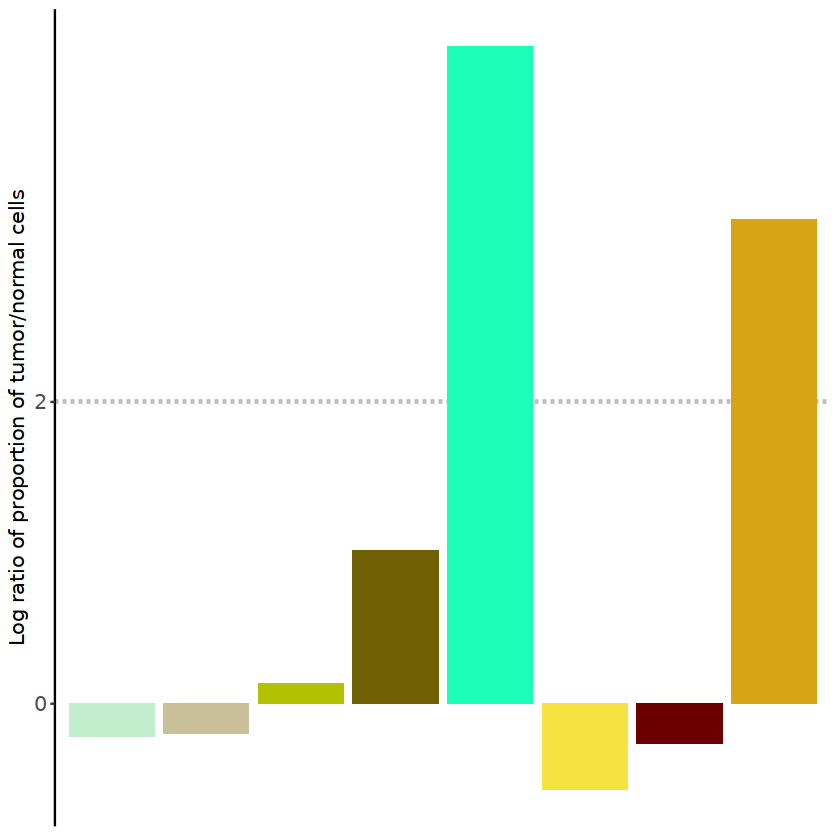

In [124]:
ggplot(proportion_df[proportion_df$annotation %in% cell_order[c(range4, range5)],], aes(x=annotation, y=log_ratio, fill=color)) +
    geom_hline(yintercept=c(2), linetype="dashed", color="gray", size = 1) +
    geom_bar(stat = "identity", show.legend = F) +
    scale_fill_identity() +
    scale_y_continuous(name="Log ratio of proportion of tumor/normal cells", breaks = c(-2, 0, 2)) + 
    theme(axis.text.x = element_blank(), axis.title.x = element_blank(), 
          axis.ticks.x = element_blank(), axis.line.x = element_blank(),
          axis.title.y = element_text(size=12), axis.text.y = element_text(size=12))

ggsave("final_figs/fig1/log_ratio_bars_cd45-.pdf",
       width = 6, height = 6)

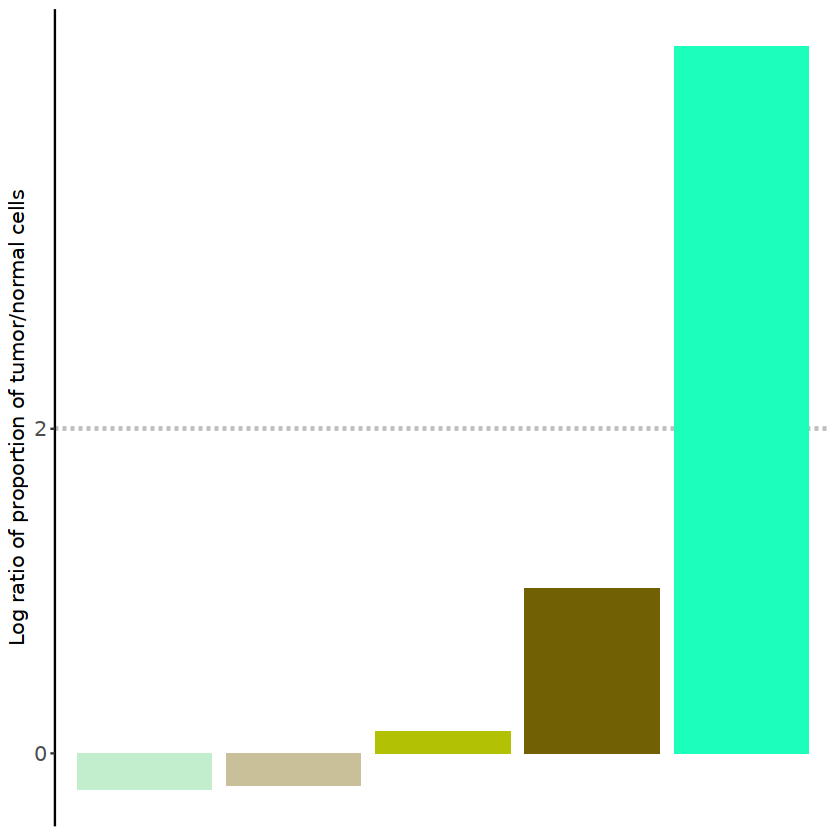

In [125]:
ggplot(proportion_df[proportion_df$annotation %in% cell_order[range4],], aes(x=annotation, y=log_ratio, fill=color)) +
    geom_hline(yintercept=c(2), linetype="dashed", color="gray", size = 1) +
    geom_bar(stat = "identity", show.legend = F) +
    scale_fill_identity() +
    scale_y_continuous(name="Log ratio of proportion of tumor/normal cells", breaks = c(-2, 0, 2)) + 
    theme(axis.text.x = element_blank(), axis.title.x = element_blank(), 
          axis.ticks.x = element_blank(), axis.line.x = element_blank(),
          axis.title.y = element_text(size=12), axis.text.y = element_text(size=12))

ggsave("final_figs/fig1/log_ratio_bars_perivasc.pdf",
       width = 6, height = 6)

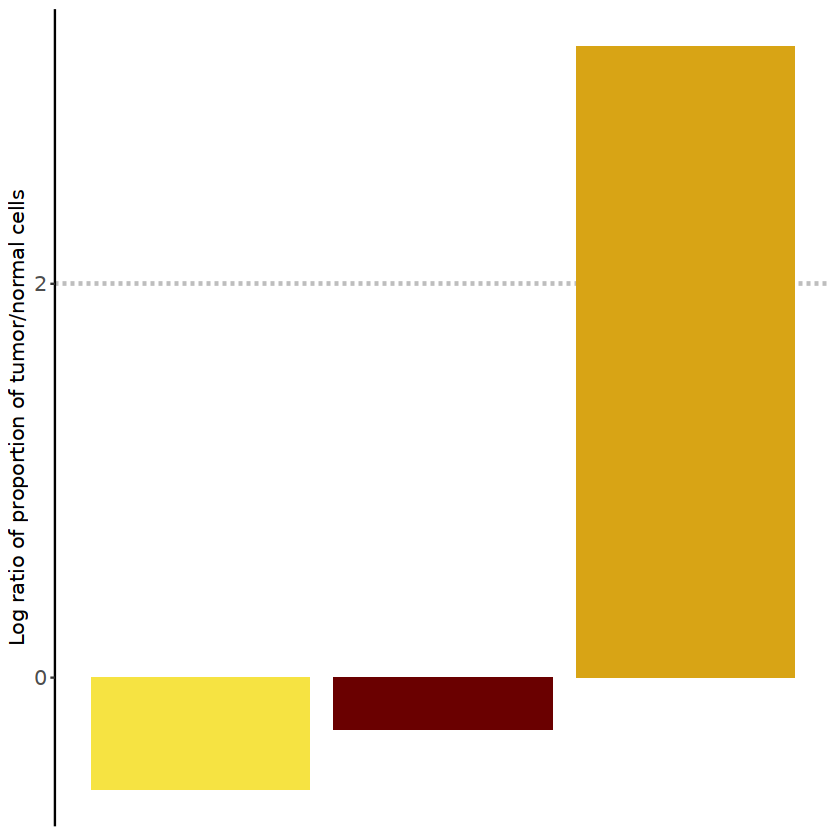

In [126]:
ggplot(proportion_df[proportion_df$annotation %in% cell_order[range5],], aes(x=annotation, y=log_ratio, fill=color)) +
    geom_hline(yintercept=c(2), linetype="dashed", color="gray", size = 1) +
    geom_bar(stat = "identity", show.legend = F) +
    scale_fill_identity() +
    scale_y_continuous(name="Log ratio of proportion of tumor/normal cells", breaks = c(-2, 0, 2)) + 
    theme(axis.text.x = element_blank(), axis.title.x = element_blank(), 
          axis.ticks.x = element_blank(), axis.line.x = element_blank(),
          axis.title.y = element_text(size=12), axis.text.y = element_text(size=12))

ggsave("final_figs/fig1/log_ratio_bars_fibrobalsts.pdf",
       width = 6, height = 6)

# Supp figure 1

In [63]:
c_vec = mc@colors[!duplicated(mc@colors)]
names(c_vec) = mc@annots[!duplicated(mc@annots)]

In [65]:
hm_genes = list(
    lymphoid=c('Cd79b', 'Ms4a1', 'Cd19', 'H2-DMb2',
               'Id2', 'S100a4', 'Il7r', 'Cxcr6', 
               'Il1rl1', 'Arg1', 'Csf2', 'Rora', 'Gata3',
               'Gzma', 'Prf1', 'Ncr1', 
               'Klrd1', 'Ccl5', 'Nkg7', 'Gzmb', 
               'Itgae', 'Trgc1', 'Trgc2', 'Trdc',
               'Icos', 'Ctla4', 'Foxp3', 'Cd4',
               'Cd8a', 'Cd8b1', 
               'Trbc2', 'Trbc1', 'Trac', 'Cd3e', 'Tcf7'),
    myeloid=c('Csf3r', 'S100a8', 'S100a9', 'Retnlg',
              'Il6', 'Mcpt8', 'Osm', 'Ccl3', 'Ccl6',
              'Fscn1', 'Epsti1', 'Ccl22', 'Ccl17',
              'Cma1', 'Cpa3', 'Tpsb2', 'Mcpt4',
              'Siglech', 'Cd209d', 'Ccr9', 
              'Clec10a', #'H2-Aa', 'H2-Ab1', 'Cd74',
              'Cd209a', 'Irf8', 'Xcr1',
              'Cx3cr1', 'Spp1', 'Trem2', 'Ms4a7',
              'C1qa', 'Tmem176a', 'Tmem176b', 'Il1b',
              'Csf1r', 'Cd163', 'Cd209f', 
              'Lyve1', 'Mrc1', 'F13a1',
              'Retnla', 'Ccr2', 'Ccl6', 'Lyz1',
              'Lyz2', 'Ear2', 'Plac8'),
    fibroblast=rev(c("Dcn", "Sparc", "Col1a1", "Col3a1", "Ly6a", "Acta2", "Ifitm3", "Anxa3", "Pi16", "Dpp4", "C3", "Pla1a",
                     "Cilp", "Cxcl14", "Spon1", "Mgp")),#, "Adipoq", "Aoc3", "Car3")),
    stromal=rev(c("Cav1", "Cdh5", "Pecam1", "Fabp5", "Cd36", "Igfbp7", "Mcam", "Lcn2", "Spp1",
                  "Tagln", "Myl9", "Myh11", 
                  "Abcc9", "Kcnj8", "Pdgfrb", "Rgs5", 
                  "Sox10", "Mbp", "Cnp", "Plp1", "Mpz", "Pmp22")),
    epithelial=rev(c("Kit", "Cd14", "Aldh1a3", "Mfge8", "Fcgbp", "Wfdc18", "Krt8", "Krt18", "Cp", 
                     "Lalba", "Csn3", 
                     "Cited1", "Pgr", "Esr1", "Prlr", 
                     "Vim", "Col16a1", "Myl9", "Cxcl14", "Acta2", "Pdpn", "Mylk", "Myh11", "Ecrg4", "Oxtr", "Tpm2", 
                     "Krt5", "Krt14", 
                     "Krt17", "Rbp1", "Rflnb", "Gja1", "Pclaf", "Tuba1b", "Hmgb2", "Ccna2",
                     "Spp1",
                     "Wap", "Csn1s1", "Csn1s2a", "Csn2", "Thrsp", "Car6", "Saa1", "Saa2"))
)

In [67]:
for (pop_name in names(hm_genes)){
    focus_genes = unlist(hm_genes[pop_name])
    write_lines(focus_genes, paste0("final_figs/supp1/heatmaps/", pop_name, "_heatmap_genes.txt"))
    focus_mc_nums = which(mc@annots %in% unlist(pop_orders[pop_name]))
    focus_mcs = match(mc@annots[mc@mc[mc@mc %in% focus_mc_nums]], cell_order) * 1000 + mc@mc[mc@mc %in% focus_mc_nums]
    focus_mat = t(mat@mat[,names(focus_mcs[order(focus_mcs, decreasing = F)])])
    focus_mat_norm = log1p(10000 * focus_mat / rowSums(focus_mat))    
    heatmap_df = as.matrix(t(focus_mat_norm[,focus_genes]))
    ha = HeatmapAnnotation(Type=factor(mc@annots[mc@mc[colnames(heatmap_df)]], 
                                       levels = cell_order[cell_order %in% mc@annots[mc@mc[colnames(heatmap_df)]]]), 
                           col = list(Type=c_vec))
    png(file=paste0("final_figs/supp1/heatmaps/", pop_name, ".png"), 
        width     = 10,
        height    = 7,
        units     = "in",
        res       = 1200,
        pointsize = 1
    )

    h = Heatmap(heatmap_df, row_names_gp = gpar(fontsize=10), show_column_dend = F,
                column_split =  factor(mc@annots[mc@mc[colnames(heatmap_df)]], 
                                       levels = cell_order[cell_order %in% mc@annots[mc@mc[colnames(heatmap_df)]]]),
                heatmap_legend_param = list(labels_gp = gpar(fontsize = 10)),
                cluster_rows = F, cluster_columns =  F, top_annotation = ha, 
                bottom_annotation = ha, show_column_names = F, name="Count",
                col = colorRampPalette(c("white", "orange", "tomato", "mediumorchid4", "midnightblue"))(1000), use_raster = F)
    plot(h)
    dev.off()
}

In [68]:
focus_genes = c(unlist(hm_genes['fibroblast']), unlist(hm_genes['stromal']))
focus_mc_nums = which(mc@annots %in% c(unlist(pop_orders['fibroblast']), unlist(pop_orders['stromal'])))
focus_mcs = match(mc@annots[mc@mc[mc@mc %in% focus_mc_nums]], cell_order) * 1000 + mc@mc[mc@mc %in% focus_mc_nums]
focus_mat = t(mat@mat[,names(focus_mcs[order(focus_mcs, decreasing = F)])])
focus_mat_norm = log1p(10000 * focus_mat / rowSums(focus_mat))    
heatmap_df = as.matrix(t(focus_mat_norm[,focus_genes]))
ha = HeatmapAnnotation(Type=factor(mc@annots[mc@mc[colnames(heatmap_df)]], 
                                   levels = cell_order[cell_order %in% mc@annots[mc@mc[colnames(heatmap_df)]]]), 
                       col = list(Type=c_vec))
png(file=paste0("final_figs/supp1/heatmaps/", 'fibro_stromal', ".png"), 
    width     = 10,
    height    = 7,
    units     = "in",
    res       = 1200,
    pointsize = 1
)

h = Heatmap(heatmap_df, row_names_gp = gpar(fontsize=10), show_column_dend = F,
            column_split =  factor(mc@annots[mc@mc[colnames(heatmap_df)]], 
                                   levels = cell_order[cell_order %in% mc@annots[mc@mc[colnames(heatmap_df)]]]),
            heatmap_legend_param = list(labels_gp = gpar(fontsize = 10)),
            cluster_rows = F, cluster_columns =  F, top_annotation = ha, 
            bottom_annotation = ha, show_column_names = F, name="Count",
            col = colorRampPalette(c("white", "orange", "tomato", "mediumorchid4", "midnightblue"))(1000), use_raster = F)
plot(h)
dev.off()


png 
  2

In [147]:
all_mat = t(mat@mat[,good_cellnames])
lognorm_mat = log1p(10000 * all_mat / rowSums(all_mat))

In [148]:
gene_names = c("Trac", "Cd79a", "Csf1r", "Csf3r", "Dcn", "Cdh5", "Krt18", "Krt14", "Saa1", "Saa2")

df_2d = data.frame(x=m2d@sc_x[good_cellnames], 
                   y=m2d@sc_y[good_cellnames]) %>% 
    cbind(as.data.frame(as.matrix(lognorm_mat[good_cellnames, gene_names])))

gbs = lapply(gene_names, function(gene_name){

    ggplot(df_2d[order(df_2d[,gene_name], decreasing = F),], aes_string(x='x', y='y', col=gene_name)) +
        geom_point(size=0.1, show.legend = F) +
        scale_color_gradientn(colors=c("ivory2", "orange", "tomato", "mediumorchid4", "midnightblue")) +
        labs(title = gene_name) +
        theme(plot.title = element_blank(),#element_text(size = 8, hjust = 0.5, face = "bold"), 
              axis.title.x = element_blank(), axis.title.y = element_blank(),
              axis.text.x = element_blank(), axis.text.y = element_blank(),
              axis.ticks.x = element_blank(), axis.ticks.y = element_blank(),
              axis.line.x = element_blank(), axis.line.y = element_blank(),
              legend.key.size = unit(0.25, 'cm'), legend.text =  element_text(size = 10))

})

In [150]:
 g <- arrangeGrob(grobs=gbs, nrow=5, respect = T) #generates g
 ggsave(file="final_figs/supp1/gene_projections_noname.png", g, width = 6, height = 16, units = 'cm', dpi=1200) #saves g

Warning message:
“Removed 1151 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 1151 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 1151 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 1151 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 1151 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 1151 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 1151 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 1151 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 1151 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 1151 rows containing missing values (`geom_point()`).”


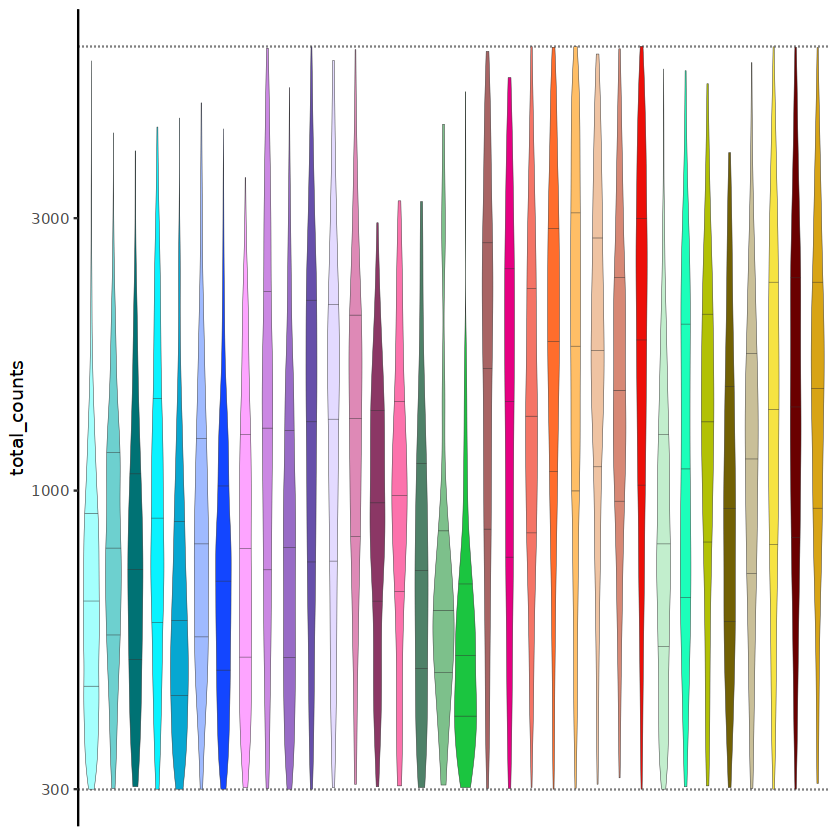

In [72]:
mat@cell_metadata[names(mc@mc[mc@annots[mc@mc] %in% cell_order]),] %>%
    mutate(annot = factor(mc@annots[metacell + 1], levels=cell_order)) %>%
    ggplot(aes(x=annot, fill=annot, y=total_counts)) +
    geom_hline(yintercept = c(300, 6000), linetype='dotted') +
    geom_violin(show.legend = F, draw_quantiles = c(0.25, 0.5, 0.75), width=1, linewidth=0.1) +
    scale_y_log10() +
    scale_fill_manual(values = c_vec) +
    theme(axis.title.x = element_blank(), axis.ticks.x = element_blank(), axis.text.x = element_blank(),
          axis.line.x = element_blank())
ggsave(filename = "final_figs/supp1/counts_per_pop.pdf", width=110, height=55, units='mm')

# Figure 2

In [68]:
if(!dir.exists("final_figs/fig2")) dir.create("final_figs/fig2/")

In [69]:
anova_df = sapply(cell_order, function(pop){
    aov_res = aov(fraction ~ Age + condition, data = replicate_df[replicate_df$annotation == pop,])
    pval_df = TukeyHSD(aov_res, which = "Age")$Age %>% as.data.frame %>% select('p adj')
    pval_df['Age', 'p adj'] = summary(aov_res)[[1]]['Age',"Pr(>F)"]
    pval_df['condition', 'p adj'] = summary(aov_res)[[1]]['condition',"Pr(>F)"]
    return(as.matrix(pval_df))
}) %>% t %>% as.data.frame

In [70]:
colnames(anova_df) = c("3w-10d", "6w-10d", "8w-10d", "10w-10d", "12w-10d", "6w-3w", "8w-3w", "10w-3w", "12w-3w", "8w-6w", 
                       "10w-6w", "12w-6w", "10w-8w", "12w-8w", "12w-10w", "Age", "condition")

In [71]:
anova_df = anova_df[c("Age", "condition", "3w-10d", "6w-10d", "8w-10d", "10w-10d", "12w-10d", "6w-3w", "8w-3w", "10w-3w", 
                      "12w-3w", "8w-6w", "10w-6w", "12w-6w", "10w-8w", "12w-8w", "12w-10w")]

In [72]:
corr_anova_df = mutate_all(anova_df, function(x){p.adjust(x, method='fdr')})

In [73]:
write.csv(corr_anova_df, "final_figs/fig2/anova_table.csv")

In [74]:
sum_df = replicate_df %>%
    group_by(annotation, Age, condition, Cell_type) %>% 
    summarise(mean_fraction=mean(fraction), sum_count=sum(Count))

sum_df$annotation = factor(sum_df$annotation, levels=cell_order)
sum_df$condition = factor(sum_df$condition, levels=cond_order)
sum_df$Age = factor(sum_df$Age, levels=age_order)

`summarise()` has grouped output by 'annotation', 'Age', 'condition'. You can
override using the `.groups` argument.


In [80]:
if(!dir.exists("final_figs/fig2/kinetic_bargraphs")) dir.create("final_figs/fig2/kinetic_bargraphs/")

for (cell_type in FACS_filters){
    plot_df = sum_df[sum_df$Cell_type == cell_type & sum_df$annotation %in% unlist(cell_type_annots[cell_type]),]
    p = ggplot(plot_df, aes(y=mean_fraction, x=1, fill=annotation)) + 
            geom_bar(position="fill", stat="identity", orientation = "x") +
            scale_fill_manual(values = group.colors[names(group.colors) %in% plot_df$annotation]) +
            facet_grid(condition ~ Age, switch = "both") +
            theme(strip.text = element_text(size=12), legend.text = element_text(size=12), axis.title.y = element_blank(),
                  legend.box.margin = margin(c(0,0,0,5)),
                  legend.title = element_text(size=12),   
                  strip.background = element_rect(linetype="blank"),
                  axis.text.y = element_blank(), axis.text.x = element_blank(), axis.title.x = element_blank(),
                  axis.ticks.x = element_blank(), axis.ticks.y = element_blank(),
                  axis.line.x = element_blank(), axis.line.y = element_blank())
    l = get_legend(p)
    p = plot_grid(p + theme(legend.position="none"))
    
    ggsave(paste0("final_figs/fig2/kinetic_bargraphs/kinetic_bars_", str_replace(cell_type, "\\+", ""), ".pdf"), plot = p, 
           width = 4, height = 6)
    ggsave(paste0("final_figs/fig2/kinetic_bargraphs/kinetic_bars_", str_replace(cell_type, "\\+", ""), "_legend.pdf"), 
           plot=l)
}

Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image


In [81]:
for (pop_name in names(pop_orders)){
    plot_df = sum_df[sum_df$annotation %in% unlist(pop_orders[pop_name]),]
    p = ggplot(plot_df, aes(y=mean_fraction, x=1, fill=annotation)) + 
            geom_bar(position="fill", stat="identity", orientation = "x") +
            scale_fill_manual(values = group.colors[names(group.colors) %in% plot_df$annotation]) +
            facet_grid(condition ~ Age, switch = "both") +
            theme(strip.text = element_text(size=12), legend.text = element_text(size=12), axis.title.y = element_blank(),
                  legend.box.margin = margin(c(0,0,0,5)),
                  legend.title = element_text(size=12),   
                  strip.background = element_rect(linetype="blank"),
                  axis.text.y = element_blank(), axis.text.x = element_blank(), axis.title.x = element_blank(),
                  axis.ticks.x = element_blank(), axis.ticks.y = element_blank(),
                  axis.line.x = element_blank(), axis.line.y = element_blank())

    l = get_legend(p)
    p = plot_grid(p + theme(legend.position="none"))

    ggsave(paste0("final_figs/fig2/kinetic_bargraphs/kinetic_bars_", pop_name, ".pdf"), plot = p, width = 4, height = 6, 
           dpi = 1200)
    ggsave(paste0("final_figs/fig2/kinetic_bargraphs/kinetic_bars_", pop_name, "_legend.pdf"), plot = l, width=4, height=6)
}

In [82]:
sum_df$broad_annotation = ifelse(sum_df$annotation %in% unique(annot_df$label)[fibroblast_order], "Fibroblast populations",
                                 ifelse(sum_df$annotation %in% unique(annot_df$label)[myeloid_order], "Myeloid populations",
                                 ifelse(sum_df$annotation %in% unique(annot_df$label)[lymphoid_order], "Lymphoid populations",
                                 ifelse(sum_df$annotation %in% unique(annot_df$label)[epithelial_order], "Epithelial populations",
                                 "Stromal populations"))))

broad_df = sum_df %>% 
    group_by(broad_annotation, Age, condition, Cell_type) %>% 
    summarise(total_frac=sum(mean_fraction))

broad_df$condition = factor(broad_df$condition, levels=cond_order)
broad_df$Age = factor(broad_df$Age, levels=age_order)

broad_order = c("Lymphoid populations", "Myeloid populations", "Epithelial populations", "Fibroblast populations", 
                "Stromal populations")
broad_df$broad_annotation = factor(broad_df$broad_annotation, levels=broad_order)
broad.colors = c("cyan3", "darkgreen", "darkgoldenrod1", "brown1", "tan")
names(broad.colors) = broad_order

`summarise()` has grouped output by 'broad_annotation', 'Age', 'condition'. You
can override using the `.groups` argument.


In [83]:
for (cell_type in unique(broad_df$Cell_type)){
    plot_df = broad_df[broad_df$Cell_type == cell_type,]
    if (cell_type == "CD45+"){plot_df = plot_df[plot_df$broad_annotation != "Epithelial populations",]}
    p = ggplot(plot_df, aes(y=total_frac, x=1, fill=broad_annotation)) + 
            geom_bar(position="fill", stat="identity", orientation = "x") +
            scale_fill_manual(values = broad.colors[names(broad.colors) %in% plot_df$broad_annotation]) +
            facet_grid(condition ~ Age, switch = "both") +
            theme(strip.text = element_text(size=12), legend.text = element_text(size=12), axis.title.y = element_blank(),
                  legend.box.margin = margin(c(0,0,0,5)),
                  legend.title = element_text(size=12),   
                  strip.background = element_rect(linetype="blank"),
                  axis.text.y = element_blank(), axis.text.x = element_blank(), axis.title.x = element_blank(),
                  axis.ticks.x = element_blank(), axis.ticks.y = element_blank(),
                  axis.line.x = element_blank(), axis.line.y = element_blank())

    l = get_legend(p)
    p = plot_grid(p + theme(legend.position="none"))

    ggsave(paste0("final_figs/fig2/kinetic_bargraphs/kinetic_bars_broad_", str_replace(cell_type, "\\+", ""), ".pdf"), 
           plot = p, width = 4, height = 6)
    ggsave(paste0("final_figs/fig2/kinetic_bargraphs/kinetic_bars_broad_", str_replace(cell_type, "\\+", ""), "_legend.pdf"), 
           plot = l, width = 4, height = 6)
}

In [344]:
if(!dir.exists("final_figs/fig2/fraction_linegraphs")) dir.create("final_figs/fig2/fraction_linegraphs/")
    

for (annot in cell_order){
    plot_df = replicate_df %>% filter(annotation == annot)
    p = ggplot(plot_df, aes(x=age_dict[Age] + ifelse(condition == "tumor", 1, -1), y=fraction, col=condition)) +
        stat_summary(fun.data="mean_se", geom='errorbar', width=2, show.legend = F, linewidth=0.2) +
        geom_point(show.legend=F, size=1.5, shape=21, , stroke=0.05) +
        geom_smooth(method = 'loess', formula=y~x, se=F, show.legend = F, linewidth=0.2) +
        scale_color_manual(values = brightness(group.colors[annot], c(0.5, 1))) +
        scale_x_continuous(name="Age", breaks = age_dict, labels = names(age_dict)) +
        labs(title=paste(annot, "fraction")) +
        theme(strip.text = element_text(size=7), plot.title = element_text(size=8, hjust=0.5),
              legend.text = element_blank(), legend.title = element_blank(), 
              legend.position = 'right',
              axis.title.y = element_blank(), axis.title.x =element_text(size=7),
              axis.text.y = element_text(size=7), axis.text.x = element_text(size=7, angle = 45, vjust = 0.5, hjust=0))

    ggsave(paste0("final_figs/fig2/fraction_linegraphs/fraction_", annot, ".pdf"), plot=p, units = 'in',
           height=2.4, width=1.4)
}

#### heatmap

In [85]:
sum_df$age_condition = factor(paste(sum_df$condition, sum_df$Age, sep="_"), levels = age_condition_order)

In [86]:
wide_df = dcast(sum_df, annotation ~ age_condition, value.var = "mean_fraction") %>% 
    column_to_rownames("annotation") %>% t %>% scale %>% t %>% as.data.frame

In [88]:
annotation_col = data.frame(condition=sapply(colnames(wide_df), function(x){unlist(str_split(x, "_"))[1]}))

In [89]:
dist_mat <- dist(wide_df, method = 'euclidean')

In [90]:
hclust_avg <- hclust(dist_mat, method = 'complete')

In [93]:
manual_order = rev(rownames(wide_df)[hclust_avg$order])

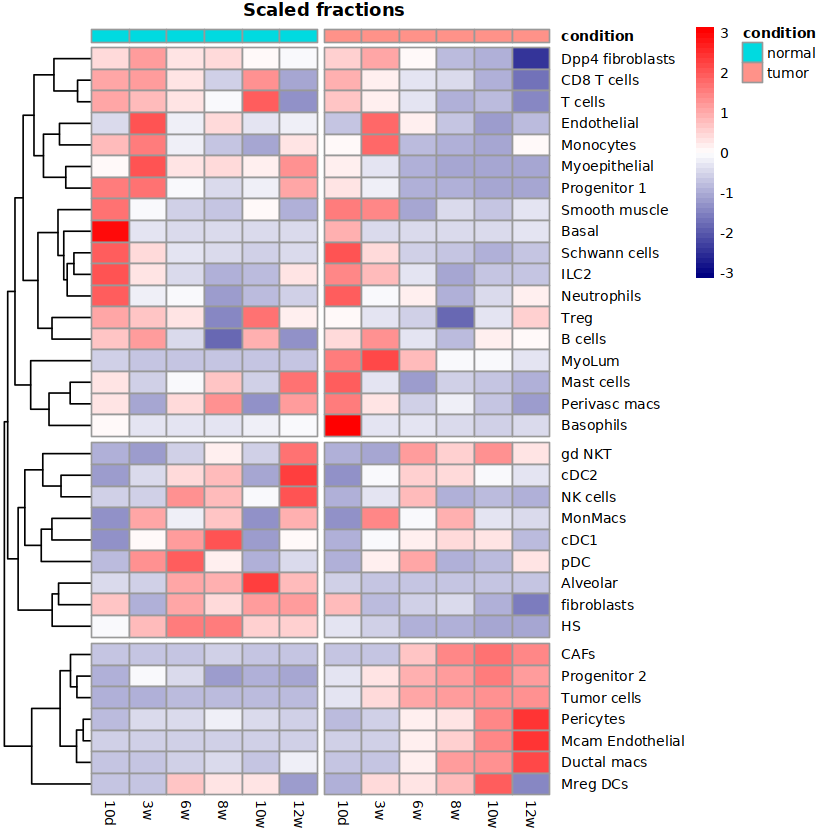

In [98]:
col_dend <- p$tree_row
col_dend <- rotate(col_dend, order = get_order(col_dend))
p = pheatmap(as.matrix(wide_df), cluster_rows=as.hclust(col_dend), main="Scaled fractions", scale = 'row', 
             treeheight_row = 50, fontsize = 8, #cellwidth = 40, cellheight = 20, 
             annotation_col = annotation_col, cluster_cols = F, cutree_rows=3, gaps_col = c(6, 12),
             labels_col = sapply(colnames(wide_df), function(x){unlist(str_split(x, "_"))[2]}),
             color=colorRampPalette(c("navy", "white", "red"))(50))

In [99]:
png("final_figs/fig2/fraction_heatmap.png", width = 18, height = 12, units = 'cm', res = 1200)
p
dev.off()

png 
  2

In [ ]:
if(!dir.exists("final_figs/fig2/fraction_linegraphs")) dir.create("final_figs/fig2/fraction_linegraphs/")
    

for (annot in cell_order){
    plot_df = replicate_df %>% filter(annotation == annot)
    p = ggplot(plot_df, aes(x=age_dict[Age] + ifelse(condition == "tumor", 1, -1), y=fraction, col=condition)) +
        stat_summary(fun.data="mean_se", geom='errorbar', width=2, show.legend = F, linewidth=0.2) +
        geom_point(show.legend=F, size=1.5, shape=21, , stroke=0.05) +
        geom_smooth(method = 'loess', formula=y~x, se=F, show.legend = F, linewidth=0.2) +
        scale_color_manual(values = brightness(group.colors[annot], c(0.5, 1))) +
        scale_x_continuous(name="Age", breaks = age_dict, labels = names(age_dict)) +
        labs(title=paste(annot, "fraction")) +
        theme(strip.text = element_text(size=7), plot.title = element_text(size=8, hjust=0.5),
              legend.text = element_blank(), legend.title = element_blank(), 
              legend.position = 'right',
              axis.title.y = element_blank(), axis.title.x =element_text(size=7),
              axis.text.y = element_text(size=7), axis.text.x = element_text(size=7, angle = 45, vjust = 0.5, hjust=0))

    ggsave(paste0("final_figs/fig2/fraction_linegraphs/fraction_", annot, ".pdf"), plot=p, units = 'in',
           height=2, width=1.4)
}

In [346]:
for (facs_filter in unique(facs_data$FACs.Filter)){
    plot_df = facs_data %>% filter(FACs.Filter == facs_filter)
    ggplot(plot_df, aes(x=age_dict[Age] + ifelse(Condition == "Tumor", 1, -1), y=Percentage, col=Condition)) +
        stat_summary(fun.data="mean_se", geom='errorbar', width=2, show.legend = F, linewidth=0.2) +
        geom_point(show.legend=F, size=1.5, shape=21, , stroke=0.05) +
        geom_smooth(method = 'loess', formula=y~x, se=F, show.legend = F, linewidth=0.2) +
        scale_x_continuous(name="Age", breaks = age_dict, labels = names(age_dict)) +
        scale_color_manual(values = brightness(facs_colors[facs_filter], c(0.5, 1))) +
        labs(title = paste0('FACs percentage - ', facs_filter)) +
        theme(strip.text = element_text(size=7), plot.title = element_text(size=8, hjust=0.5),
              legend.text = element_blank(), legend.title = element_blank(), 
              legend.position = 'right',
              axis.title.y = element_blank(), axis.title.x =element_text(size=7),
              axis.text.y = element_text(size=7), axis.text.x = element_text(size=7, angle = 45, vjust = 0.5, hjust=0))

    ggsave(paste0("final_figs/supp1/facs/", str_replace(facs_filter, "/", "_"), ".pdf"), units='in',
           height=2, width=1.4)
}

Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“pseudoinverse used at 85.37”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“neighborhood radius 28.37”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“reciprocal condition number  1.2913e-16”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“There are other near singularities as well. 196”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“pseudoinverse used at 83.37”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“neighborhood radius 28.37”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“reciprocal condition number  4.139e-17”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“There are other near singulari

Saving 6.67 x 6.67 in image


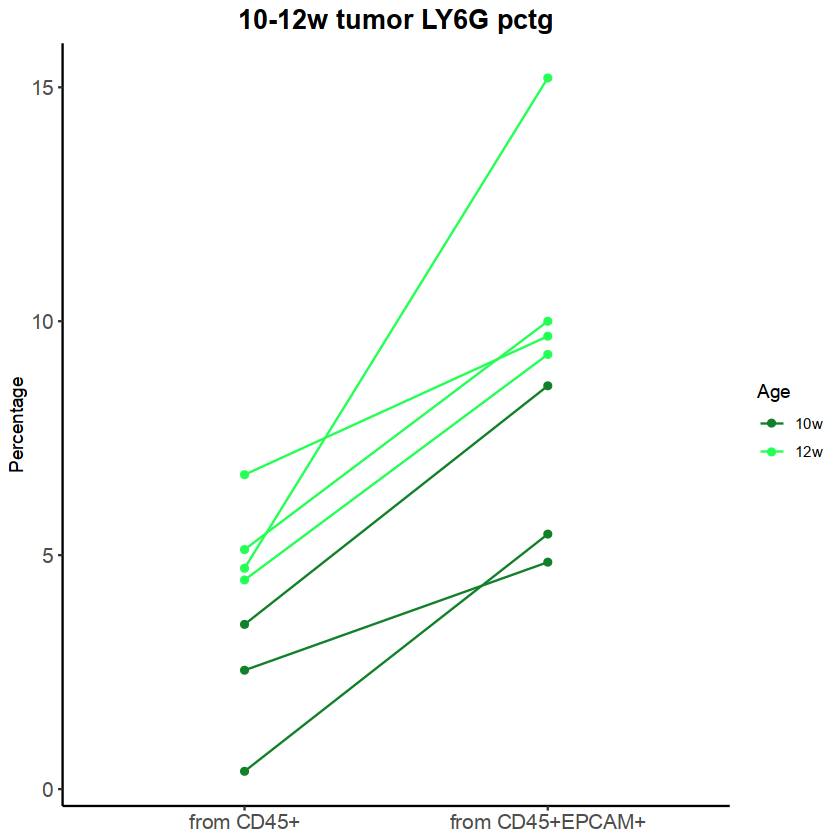

In [294]:
facs_data[facs_data$FACs.Filter %in% c('LY6G', 'LY6G/EPCAM') & facs_data$Age %in% c('10w', '12w') & 
          facs_data$Condition == 'Tumor',] %>%
    ggplot(aes(x=FACs.Filter, y=Percentage, color=Age, group=batch_name)) +
        geom_point() +
        geom_line() +
        labs(title = '10-12w tumor LY6G pctg') +
        scale_color_manual(values = brightness(group.colors['Neutrophils'], c(0.5, 1.5))) +
        scale_x_discrete(labels=c('from CD45+', 'from CD45+EPCAM+')) +
        theme(axis.title.x=element_blank(), axis.text = element_text(size=12),
              plot.title = element_text(hjust=0.5, size=16, face = 'bold'))
ggsave('final_figs/fig3/ly6g_singlet_vs_pics.pdf')

In [295]:
test_df = facs_data[facs_data$FACs.Filter %in% c('LY6G', 'LY6G/EPCAM') & facs_data$Age %in% c('10w', '12w') & 
          facs_data$Condition == 'Tumor',] %>% 
    dcast(FACs.Filter ~ batch_name, value.var = 'Percentage') %>% 
    column_to_rownames('FACs.Filter') %>% t %>% as.data.frame

In [296]:
wilcox.test(test_df$LY6G, test_df$`LY6G/EPCAM`, paired = T)


	Wilcoxon signed rank exact test

data:  test_df$LY6G and test_df$`LY6G/EPCAM`
V = 0, p-value = 0.01563
alternative hypothesis: true location shift is not equal to 0


In [321]:
test_df = facs_data[facs_data$FACs.Filter %in% c('EPCAM') & facs_data$Age %in% c('6w', '8w', '10w', '12w'),] %>% 
    mutate(date=ifelse(replace_na(batch_name == "Sandra-10w-7", F), "2024-06-05b", as.character(date))) %>%
    dcast(Condition ~ date, value.var = 'Percentage') %>% 
    column_to_rownames('Condition') %>% t %>% as.data.frame

In [322]:
wilcox.test(test_df$Tumor, test_df$Normal, paired = F)

Warning message in wilcox.test.default(test_df$Tumor, test_df$Normal, paired = F):
“cannot compute exact p-value with ties”



	Wilcoxon rank sum test with continuity correction

data:  test_df$Tumor and test_df$Normal
W = 221, p-value = 4.14e-06
alternative hypothesis: true location shift is not equal to 0


# Depletion bars

In [301]:
endo_bar = read.csv('depletion_dges/endo_genes_new.csv') %>% t %>% as.data.frame

In [302]:
endo_bar = endo_bar[2:13,c(1,3:4)]
colnames(endo_bar) = c('metric', 'Isotype', 'Depletion')
endo_bar = endo_bar %>% 
    rownames_to_column('gene') %>% 
    mutate(gene=str_split_i(gene, "\\.", 1), Isotype=as.numeric(Isotype), Depletion=as.numeric(Depletion))

Using gene, metric as id variables



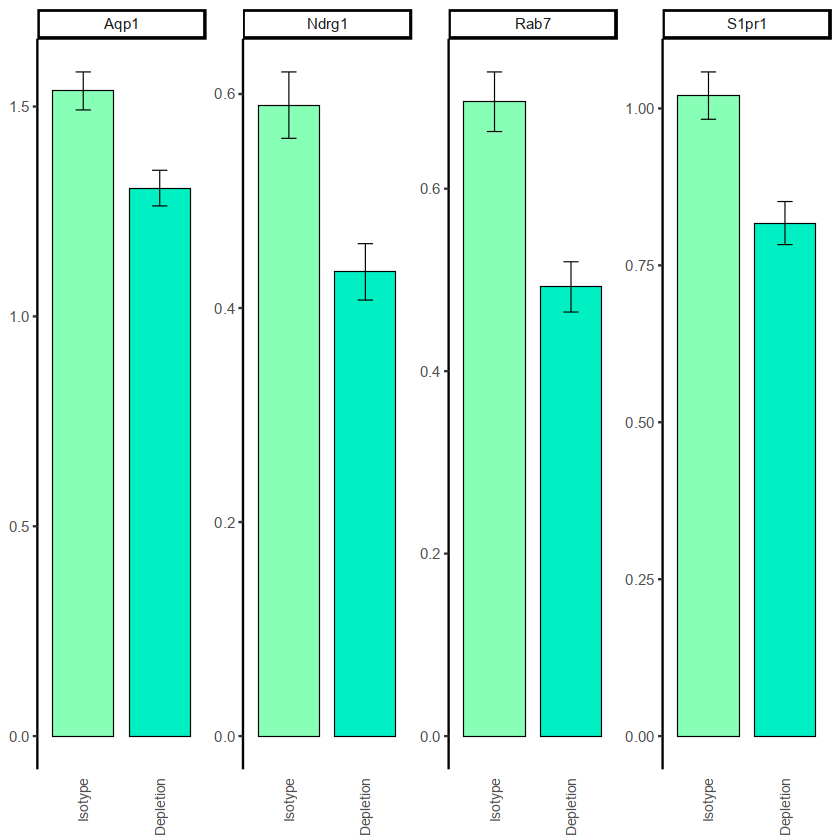

In [303]:
endo_bar %>%
    melt(variable.name = 'Treatment') %>%
    dcast(gene+Treatment ~ metric) %>%
    mutate(sem=std / (count ** 0.5)) %>%
    ggplot(aes(x=Treatment, y=mean, fill=Treatment)) +
    geom_bar(stat = 'identity', show.legend = F, color='black', width=0.8, linewidth=0.25) +
    geom_errorbar(aes(ymin=mean-sem, ymax=mean+sem), width=0.2, linewidth=0.25) +
    facet_wrap(~gene, scales='free', ncol = 4) +
    scale_fill_manual(values=c('#88ffb6', '#00efc3')) +
    theme(axis.text.x = element_text(angle=90, vjust=0.5, hjust=1, size=8), 
          axis.title.x = element_blank(), axis.title.y = element_blank(),
          axis.line.x = element_blank(), axis.ticks.x=element_blank())
ggsave('depletion_dges/endo_bar_new.pdf', height=2.5, width=3)

In [380]:
epi_bar = read.csv('depletion_dges/epi_genes_new.csv') %>% t %>% as.data.frame

In [381]:
epi_bar = epi_bar[2:13,c(1,3:4)]
colnames(epi_bar) = c('metric', 'Isotype', 'Depletion')
epi_bar = epi_bar %>% 
    rownames_to_column('gene') %>% 
    mutate(gene=str_split_i(gene, "\\.", 1), Isotype=as.numeric(Isotype), Depletion=as.numeric(Depletion))

Using gene, metric as id variables



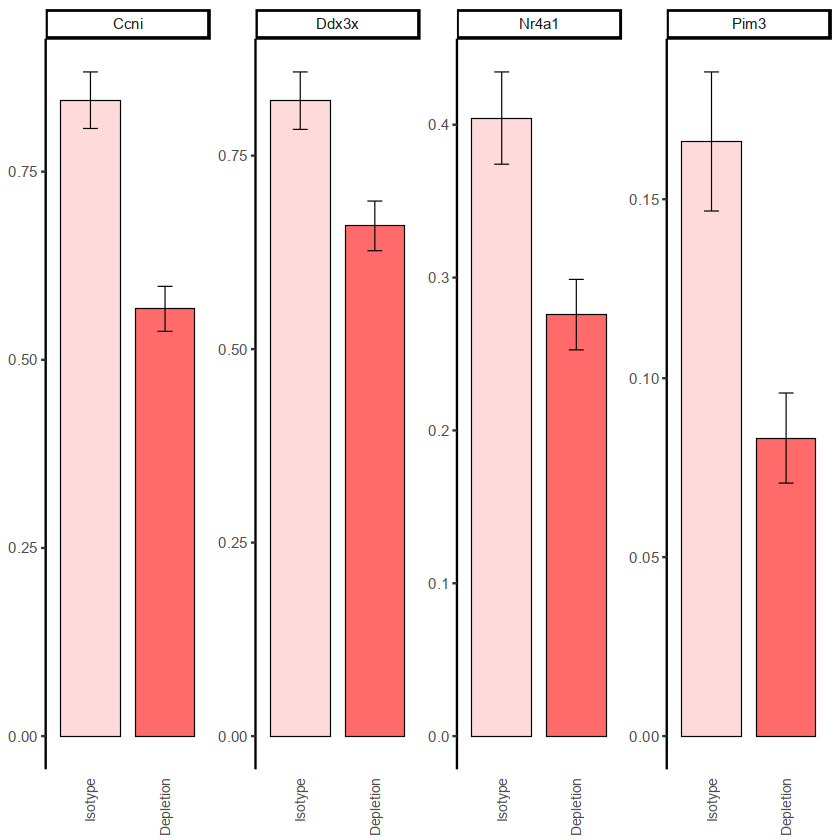

In [382]:
epi_bar %>%
    melt(variable.name = 'Treatment') %>%
    dcast(gene+Treatment ~ metric) %>%
    mutate(sem=std / (count ** 0.5)) %>%
    ggplot(aes(x=Treatment, y=mean, fill=Treatment)) +
    geom_bar(stat = 'identity', show.legend = F, color='black', width=0.8, linewidth=0.25) +
    geom_errorbar(aes(ymin=mean-sem, ymax=mean+sem), width=0.2, linewidth=0.25) +
    facet_wrap(~gene, scales='free', ncol = 4) +
    scale_fill_manual(values=c('#ffdada', '#ff6a6a')) +
    theme(axis.text.x = element_text(angle=90, vjust=0.5, hjust=1, size=8),
          axis.title.x = element_blank(), axis.title.y = element_blank(),
          axis.line.x = element_blank(), axis.ticks.x=element_blank())
ggsave('depletion_dges/epi_bar_new.pdf', height=2.5, width=3)